In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None) ## 모든 열을 출력한다.
# pd.set_option('display.max_rows', None)

import seaborn as sns
import matplotlib.pyplot as plt

import datetime
from dateutil.parser import parse
from tqdm import tqdm

import lightgbm as lgb
import bisect

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

# Unicode warning 제거 (폰트 관련 경고메시지)
plt.rcParams['axes.unicode_minus']=False

# 그래프 출력 사이즈 설정
plt.rcParams["figure.figsize"] = (10, 10)

sns.set(font="Hancom Gothic", 
        rc={"axes.unicode_minus":False}, # 마이너스 부호 깨짐 현상 해결
        style='darkgrid')

# 가. 데이터 불러오기

In [86]:
pd.read_csv('./Data/train.csv').head()

,SAMPLE_ID,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
0,TRAIN_000000,SG,GIW5,Container,30.881018,2018-12-17 21:29,Z618338,30.0,24,24300,10.0,10.0,16700,180.0,CQSB78,Panama,NaN,NaN,NaN,NaN,5,0.002615,3.450000
1,TRAIN_000001,IN,UJM2,Bulk,0.000000,2014-09-23 6:59,X886125,30.0,13,35900,10.0,10.0,23500,180.0,SPNO34,Marshall Islands,NaN,NaN,NaN,NaN,12,0.000217,0.000000
2,TRAIN_000002,CN,EUC8,Container,0.000000,2015-02-03 22:00,T674582,50.0,12,146000,30.0,20.0,140000,370.0,FNPK22,Malta,NaN,NaN,NaN,NaN,6,0.001614,0.000000
3,TRAIN_000003,JP,ZAG4,Container,0.000000,2020-01-17 4:02,Y847238,20.0,18,6910,10.0,10.0,5400,120.0,PBZV77,Bahamas,-3.18,-1.61,6.7,2.629350,13,0.000356,0.000000
4,TRAIN_000004,SG,GIW5,Container,27.037650,2020-01-26 7:51,A872328,50.0,10,116000,20.0,10.0,96600,300.0,GUCE76,Liberia,-0.33,-3.28,25.6,2.495953,15,0.002615,253.554444


In [56]:
train = pd.read_csv('./Data/train(인코딩 후).csv')
test = pd.read_csv('./Data/test(인코딩 후).csv')

In [57]:
train.head(2)

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR,YEAR,MONTH,DAY,HOUR,MINUTE,WEEKDAY
0,17,21,2,30.881018,24709,30.0,24,24300,10.0,10.0,16700,180.0,686,89,-0.29491,-0.263841,18.86294,2.706997,5,0.002615,3.45,2018,12,17,21,29,0
1,7,81,0,0.000000,23139,30.0,13,35900,10.0,10.0,23500,180.0,4719,74,-0.29491,-0.263841,18.86294,2.706997,12,0.000217,0.00,2014,9,23,6,59,1


In [58]:
test.head(2)

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,YEAR,MONTH,DAY,HOUR,MINUTE,WEEKDAY
0,18,22,3,1.826589,9788,50.0,18,117000,30.0,20.0,109000,340.0,2688,90,0.37,1.63,27.1,1.587063,19,0.002615,2020,6,18,11,58,3
1,5,91,2,25.399386,4184,10.0,13,3810,10.0,10.0,2560,80.0,2796,11,-2.79,-2.33,14.2,2.663972,6,0.001028,2021,5,26,22,20,2


# 다. 데이터 정규화/스케일링(Normalizing/Scaling)

In [59]:
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [60]:
# X_train[:2], y_train[:2] #0~1사이로 숫자들이 바뀜 - 정규화

### 나. X, Y 분리

In [61]:
X = train.drop('CI_HOUR', axis=1)
y = train['CI_HOUR']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((274356, 26), (274356,), (117582, 26), (117582,))

In [10]:
test.values

array([[18., 22.,  3., ..., 11., 58.,  3.],
       [ 5., 91.,  2., ..., 22., 20.,  2.],
       [ 5., 46.,  3., ...,  0.,  9.,  0.],
       ...,
       [ 9., 89.,  4., ..., 14., 53.,  6.],
       [ 5., 63.,  2., ..., 14., 38.,  0.],
       [13., 54.,  3., ...,  6., 34.,  5.]])

# 라. 모델 개발

#### 1. 모델별 바차트 그려주고 성능 확인을 위한 함수

In [11]:
# 모델별로 Accuracy 점수 저장
# 모델 Accuracy 점수 순서대로 바차트를 그려 모델별로 성능 확인 가능
#가져다가 쓰면됨
from sklearn.metrics import roc_auc_score, accuracy_score, r2_score, mean_absolute_error

my_predictions_mae = {}
my_predictions_r2 = {}

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive', 
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray', 
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato'
         ]

# 모델명, 예측값, 실제값을 주면 위의 plot_predictions 함수 호출하여 Scatter 그래프 그리며
# 모델별 mae값을 Bar chart로 그려줌

# mean_squared_error(y_test,pred_y)**0.5
# r2_score(y_test,pred_y)
    
def regression_eval(name_, pred, actual):
    global predictions
    global colors

    plt.figure(figsize=(9, 12))

    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    
    my_predictions_mae[name_] = mae
    my_predictions_r2[name_] = r2

    y_mae_value = sorted(my_predictions_mae.items(), key=lambda x: x[1], reverse=True)
    y__r2_value = sorted(my_predictions_r2.items(), key=lambda x: x[1], reverse=True)
    
    df_mae = pd.DataFrame(y_mae_value, columns=['model', 'mae'])
    df_r2 = pd.DataFrame(y__r2_value, columns=['model', 'r2'])
    
    print(df_mae)
    print(df_r2)
   
    length = len(df_mae)
    length = len(df_r2)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (9,3), constrained_layout=True)
    
    # ----
    # ax = plt.subplot(1,2,1)
    ax1.set_yticks(np.arange(len(df_mae)))
    ax1.set_yticklabels(df_mae['model'], fontsize=15)
    bars = ax1.barh(np.arange(len(df_mae)), df_mae['mae'])
    
    for i, v in enumerate(df_mae['mae']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax1.text(v + 2, i, str(round(v, 3)), color='k', fontsize=11, fontweight='bold')
    
    ax1.set_title('Mean Absolute Error')
    ax1.set_xlim(right = 200)
    
    # ----
    ax2 = plt.subplot(1,2,2)
    ax2.set_yticks(np.arange(len(df_r2)))
    ax2.set_yticklabels(df_r2['model'], fontsize=15)
    bars = ax2.barh(np.arange(len(df_r2)), df_r2['r2'])
     
    for i, v in enumerate(df_r2['r2']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax2.text(v + 0.01, i, str(round(v, 3)), color='k', fontsize=11, fontweight='bold')
    
    ax2.set_title('R2')
    ax2.set_xlim(right = 1)
    
    # plt.title('mae', fontsize=18)
    
    plt.show()

In [20]:
def train_and_evaluate(model, model_name, X_train, y_train, X_test, y_test):
    print(f'Model Tune for {model_name}.')
    fit_model = model.fit(X_train, y_train)
    
    feature_importances = fit_model.feature_importances_
    sorted_idx = feature_importances.argsort()

    y_pred = fit_model.predict(X_test)
    print("MAE on Test set : {0:.5f}".format(mean_absolute_error(y_test, y_pred)))
    print("R-squared Score on Test set : {0:.5f}".format(r2_score(y_test, y_pred)))

    plt.figure(figsize=(5, 8))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()
    
    return fit_model, feature_importances


###  
### 1) 다중선형회귀 (LinearRegression)

In [13]:
from sklearn.linear_model import LinearRegression as lr
from sklearn.metrics import roc_auc_score, accuracy_score, mean_absolute_error, r2_score

In [14]:
model = lr()
model.fit(X_train, y_train)

print("모델의 회귀계수는 : ", model.coef_, "\n모델의 절편은 : ",model.intercept_, '\n')

y_pred = model.predict(X_test)
print("MAE on Test set : {0:.5f}".format(mean_absolute_error(y_test, y_pred)))
print("R-squared Score on Test set : {0:.5f}".format(r2_score(y_test, y_pred)))

모델의 회귀계수는 :  [ 2.10450497e+00  1.00392038e-02 -1.97538564e+01  1.09520583e+00
 -1.47373173e-04 -8.33540809e-01  7.95409232e-01  1.57792729e-04
  1.21816458e+00 -1.59497832e+00  6.59621042e-04 -2.46028249e-01
 -1.08944498e-04  1.17877728e-01 -2.97752825e-01 -2.37350773e-01
  5.75718794e-01 -2.25125425e+00  1.41738773e-01  6.06991975e+03
  1.57826811e+00  1.70673490e-01 -1.42925455e-02  2.38761228e-01
  1.10350015e-01  7.77399375e+00] 
모델의 절편은 :  -3160.065456119964 

MAE on Test set : 72.56008
R-squared Score on Test set : 0.06875


              model        mae
0  LinearRegression  72.560081
              model        r2
0  LinearRegression  0.068747


<Figure size 900x1200 with 0 Axes>

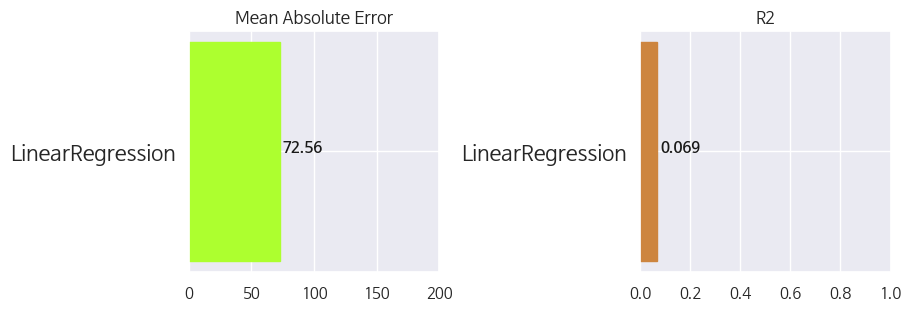

In [15]:
regression_eval('LinearRegression', y_pred, y_test)

###   
### 2) KNN (K-Nearest Neighbor)

In [20]:
from sklearn.neighbors import KNeighborsRegressor

In [21]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsRegressor()

In [22]:
knn_pred = knn.predict(X_test)

                model        mae
0    LinearRegression  72.560081
1  K-Nearest Neighbor  68.043355
                model        r2
0    LinearRegression  0.068747
1  K-Nearest Neighbor  0.020428


<Figure size 900x1200 with 0 Axes>

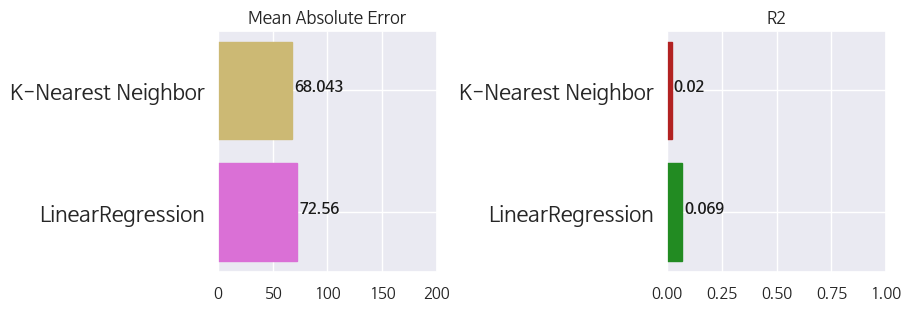

In [23]:
regression_eval('K-Nearest Neighbor', knn_pred, y_test) #성능비교

###  
### 3) 결정트리(DecisionTree)

In [18]:
from sklearn.tree import DecisionTreeRegressor

Model Tune for DecisionTreeRegressor.
MAE on Test set : 70.41638
R-squared Score on Test set : -0.49803


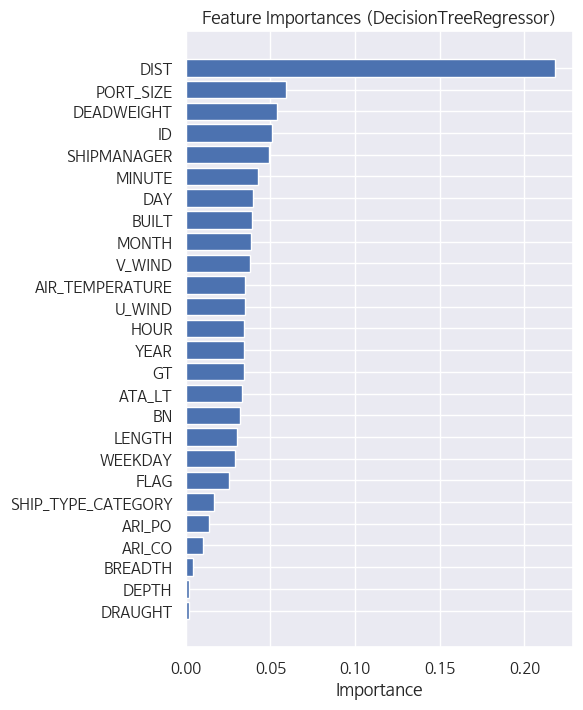

In [21]:
dt, feature_importances = train_and_evaluate(DecisionTreeRegressor(random_state=42), 'DecisionTreeRegressor', X_train, y_train, X_test, y_test)

In [23]:
data = {'DecisionTreeRegressor' : [score for score in dt.feature_importances_]}
feature_importances_df = pd.DataFrame(data, index=X.columns)

In [24]:
dt_pred = dt.predict(X_test)

              model        mae
0  LinearRegression  72.560081
1      DecisionTree  70.416376
              model        r2
0  LinearRegression  0.068747
1      DecisionTree -0.498026


<Figure size 900x1200 with 0 Axes>

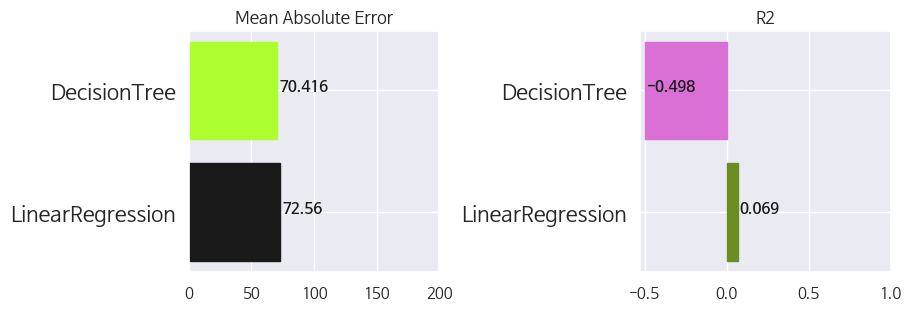

In [25]:
regression_eval('DecisionTree', dt_pred, y_test)
#바 차트 그리기

### 
### **앙상블 기법의 종류**
- 배깅 (Bagging): 여러개의 DecisionTree 활용하고 샘플 중복 생성을 통해 결과 도출. RandomForest
- 부스팅 (Boosting): 약한 학습기를 순차적으로 학습을 하되, 이전 학습에 대하여 잘못 예측된 데이터에 가중치를 부여해 오차를 보완해 나가는 방식. XGBoost, LGBM
- 스태킹 (Stacking): 여러 모델을 기반으로 예측된 결과를 통해 Final 학습기(meta 모델)이 다시 한번 예측

![앙상블](https://teddylee777.github.io/images/2019-12-18/image-20191217144823555.png)

###  
### 4) 랜덤포레스트(RandomForest)
+ Bagging 대표적인 모델로써, 훈련셋트를 무작위로 각기 다른 서브셋으로 데이터셋을 만들고
+ 여러개의 DecisonTree로 학습하고 다수결로 결정하는 모델

**주요 Hyperparameter**
- random_state: 랜덤 시드 고정 값. 고정해두고 튜닝할 것!
- n_jobs: CPU 사용 갯수
- max_depth: 깊어질 수 있는 최대 깊이. 과대적합 방지용
- n_estimators: 앙상블하는 트리의 갯수
- max_features: 최대로 사용할 feature의 갯수. 과대적합 방지용
- min_samples_split: 트리가 분할할 때 최소 샘플의 갯수. default=2. 과대적합 방지용

In [27]:
from sklearn.ensemble import RandomForestRegressor

Model Tune for DecisionTreeRegressor.
MAE on Test set : 55.90010
R-squared Score on Test set : 0.28785


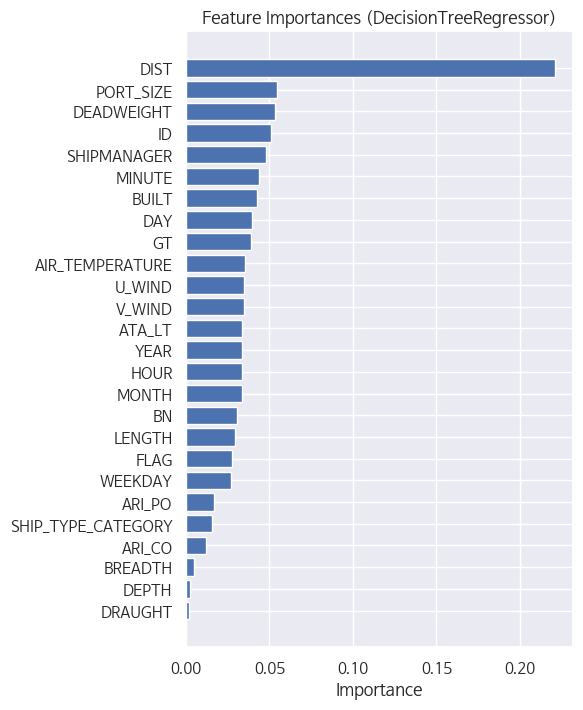

In [28]:
rfc, feature_importances = train_and_evaluate(RandomForestRegressor( random_state=42), 'DecisionTreeRegressor', X_train, y_train, X_test, y_test)

In [29]:
feature_importances_df['RandomForest Ensemble'] = [score for score in rfc.feature_importances_]
feature_importances_df.head(3)

,DecisionTreeRegressor,RandomForest Ensemble
ARI_CO,0.010032,0.012308
ARI_PO,0.013866,0.016935
SHIP_TYPE_CATEGORY,0.016621,0.015593


In [30]:
rfc_pred = rfc.predict(X_test)

                   model        mae
0       LinearRegression  72.560081
1           DecisionTree  70.416376
2  RandomForest Ensemble  55.900098
                   model        r2
0  RandomForest Ensemble  0.287852
1       LinearRegression  0.068747
2           DecisionTree -0.498026


<Figure size 900x1200 with 0 Axes>

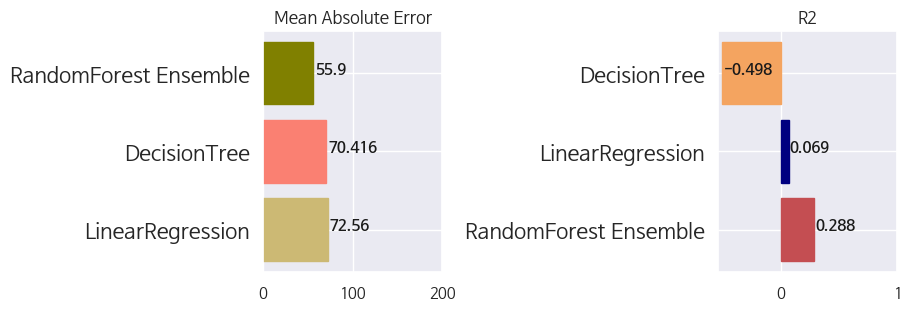

In [31]:
regression_eval('RandomForest Ensemble', rfc_pred, y_test)

###  
### 5) XGBoost
+ 여러개의 DecisionTree를 결합하여 Strong Learner 만드는 Boosting 앙상블 기법
+ Kaggle 대회에서 자주 사용하는 모델이다.

**주요 특징**
- scikit-learn 패키지가 아닙니다.
- 성능이 우수함
- GBM보다는 빠르고 성능도 향상되었습니다.
- 여전히 학습시간이 매우 느리다

**주요 Hyperparameter**
- random_state: 랜덤 시드 고정 값. 고정해두고 튜닝할 것!
- n_jobs: CPU 사용 갯수
- learning_rate: 학습율. 너무 큰 학습율은 성능을 떨어뜨리고, 너무 작은 학습율은 학습이 느리다. 적절한 값을 찾아야함. n_estimators와 같이 튜닝. default=0.1
- n_estimators: 부스팅 스테이지 수. (랜덤포레스트 트리의 갯수 설정과 비슷한 개념). default=100
- max_depth: 트리의 깊이. 과대적합 방지용. default=3. 
- subsample: 샘플 사용 비율. 과대적합 방지용. default=1.0
- max_features: 최대로 사용할 feature의 비율. 과대적합 방지용. default=1.0

In [115]:
# !pip install xgboost

In [32]:
from xgboost import XGBRegressor

Model Tune for XGBRegressor.
MAE on Test set : 56.44413
R-squared Score on Test set : 0.29716


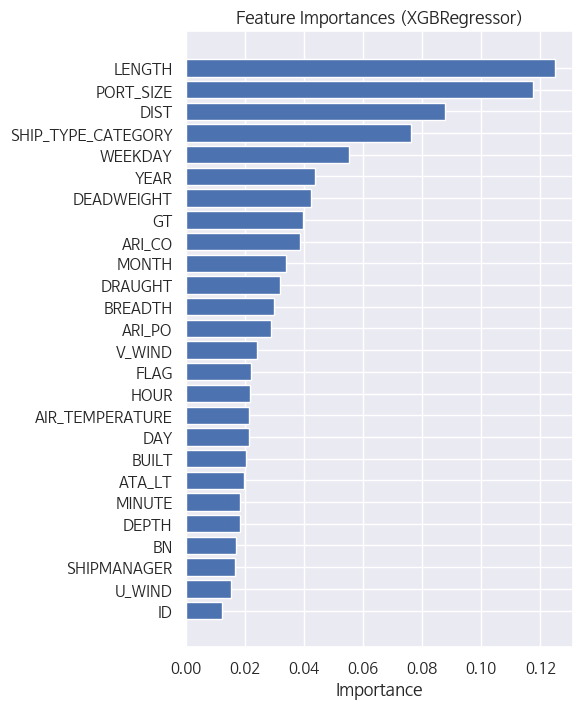

In [33]:
xgb, feature_importances = train_and_evaluate(XGBRegressor(random_state=42), 'XGBRegressor', X_train, y_train, X_test, y_test)

In [34]:
feature_importances_df['XGBoost'] = [score for score in xgb.feature_importances_]
feature_importances_df.head(3)

,DecisionTreeRegressor,RandomForest Ensemble,XGBoost
ARI_CO,0.010032,0.012308,0.038789
ARI_PO,0.013866,0.016935,0.028978
SHIP_TYPE_CATEGORY,0.016621,0.015593,0.076203


In [35]:
xgb_pred = xgb.predict(X_test)

                   model        mae
0       LinearRegression  72.560081
1           DecisionTree  70.416376
2                XGBoost  56.444126
3  RandomForest Ensemble  55.900098
                   model        r2
0                XGBoost  0.297160
1  RandomForest Ensemble  0.287852
2       LinearRegression  0.068747
3           DecisionTree -0.498026


<Figure size 900x1200 with 0 Axes>

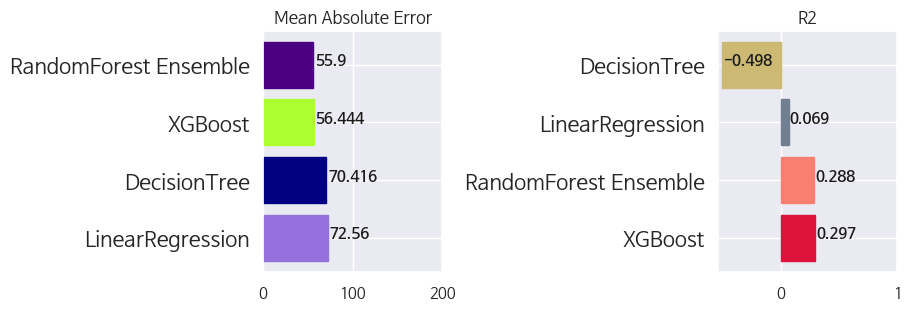

In [36]:
regression_eval('XGBoost', xgb_pred, y_test)

###  
### 6) Light GBM
+ XGBoost와 함께 주목받는 DecisionTree 알고리즘 기반의 Boosting 앙상블 기법
+ XGBoost에 비해 학습시간이 짧은 편이다.

**주요 특징**
- scikit-learn 패키지가 아닙니다.
- 성능이 우수함
- 속도도 매우 빠릅니다.

**주요 Hyperparameter**
- random_state: 랜덤 시드 고정 값. 고정해두고 튜닝할 것!
- n_jobs: CPU 사용 갯수
- learning_rate: 학습율. 너무 큰 학습율은 성능을 떨어뜨리고, 너무 작은 학습율은 학습이 느리다. 적절한 값을 찾아야함. n_estimators와 같이 튜닝. default=0.1
- n_estimators: 부스팅 스테이지 수. (랜덤포레스트 트리의 갯수 설정과 비슷한 개념). default=100
- max_depth: 트리의 깊이. 과대적합 방지용. default=3. 
- colsample_bytree: 샘플 사용 비율 (max_features와 비슷한 개념). 과대적합 방지용. default=1.0

In [120]:
# !pip install lightgbm #싸이킬런 아니라 별도로 섪치

In [38]:
from lightgbm import LGBMRegressor

Model Tune for XGBRegressor.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2916
[LightGBM] [Info] Number of data points in the train set: 274356, number of used features: 26
[LightGBM] [Info] Start training from score 61.990887
MAE on Test set : 55.94962
R-squared Score on Test set : 0.28186


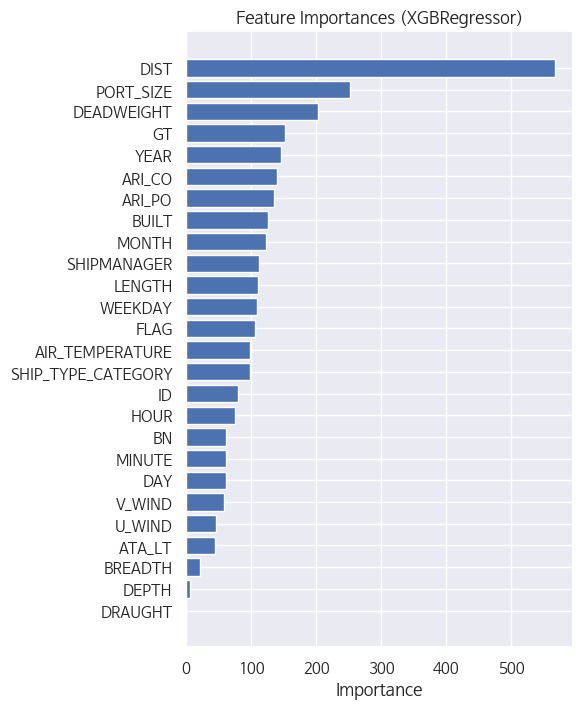

In [39]:
lgbm, feature_importances = train_and_evaluate(LGBMRegressor(random_state=42), 'XGBRegressor', X_train, y_train, X_test, y_test)

In [40]:
feature_importances_df['LGBM'] = [score for score in lgbm.feature_importances_]
feature_importances_df.head(3)

,DecisionTreeRegressor,RandomForest Ensemble,XGBoost,LGBM
ARI_CO,0.010032,0.012308,0.038789,140
ARI_PO,0.013866,0.016935,0.028978,136
SHIP_TYPE_CATEGORY,0.016621,0.015593,0.076203,98


In [41]:
lgbm_pred = lgbm.predict(X_test)

                   model        mae
0       LinearRegression  72.560081
1           DecisionTree  70.416376
2                XGBoost  56.444126
3                   LGBM  55.949619
4  RandomForest Ensemble  55.900098
                   model        r2
0                XGBoost  0.297160
1  RandomForest Ensemble  0.287852
2                   LGBM  0.281863
3       LinearRegression  0.068747
4           DecisionTree -0.498026


<Figure size 900x1200 with 0 Axes>

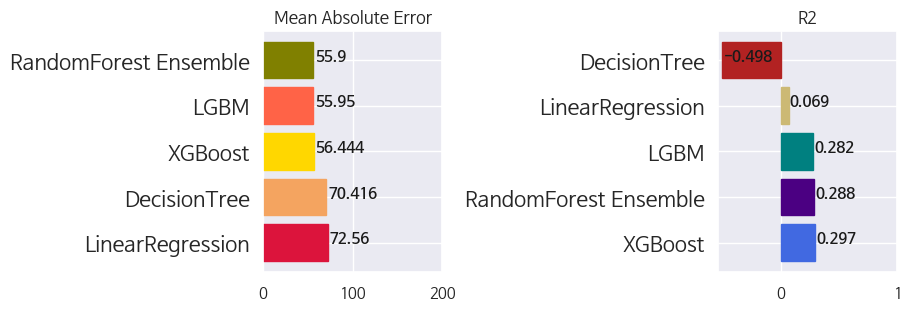

In [42]:
regression_eval('LGBM', lgbm_pred, y_test)

In [125]:
dsf

NameError: name 'dsf' is not defined

In [44]:
feature_importances_df.to_excel('./컬럼명.xlsx')

---

In [212]:
X_train = train.drop('CI_HOUR', axis=1)
y_train = train['CI_HOUR']

In [65]:
threshold = 85 # Your Threshold
low_importance_features = X.columns[feature_importances < threshold]


X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = X_test.drop(columns=low_importance_features)

print(X_train_reduced.columns)

if (len(X_train_reduced.columns) < 1):
    print('없음')

Index(['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'BUILT', 'DEADWEIGHT',
       'GT', 'LENGTH', 'SHIPMANAGER', 'FLAG', 'AIR_TEMPERATURE', 'PORT_SIZE',
       'YEAR', 'MONTH', 'WEEKDAY'],
      dtype='object')


In [82]:
X_train_reduced

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,BUILT,DEADWEIGHT,GT,LENGTH,SHIPMANAGER,FLAG,AIR_TEMPERATURE,PORT_SIZE,YEAR,MONTH,WEEKDAY
57968,4,13,0,22.706314,12,75600,40900,220.0,6242,20,7.70000,0.001660,2019,4,2
225577,8,66,1,13.017661,19,3820,2960,80.0,659,89,16.00000,0.000552,2022,10,2
165424,3,22,0,1.254201,16,56000,31200,190.0,3374,89,18.86294,0.000017,2017,1,4
265675,4,44,2,0.000000,29,8700,7170,130.0,3793,50,24.20000,0.000939,2019,6,3
20475,19,35,2,0.000000,30,7480,5300,130.0,3793,50,18.86294,0.000990,2017,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,16,82,0,7.782000,3,81600,43600,230.0,6352,89,8.90000,0.000058,2021,12,0
365838,4,62,2,23.777186,8,12400,9860,140.0,4136,89,18.86294,0.000595,2017,8,4
131932,4,44,1,0.000000,23,44700,33400,200.0,553,86,23.60000,0.000939,2022,5,3
146867,17,21,2,0.000000,7,110000,95500,300.0,2687,94,18.86294,0.002615,2018,4,3


In [78]:
y_test

115221      86.912500
298713     131.016944
296705       0.000000
144551      12.088611
231956       0.000000
             ...     
314056    1882.813333
70951        0.000000
309286       3.550000
184835       0.000000
143657       0.000000
Name: CI_HOUR, Length: 117582, dtype: float64

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1742
[LightGBM] [Info] Number of data points in the train set: 219484, number of used features: 15
[LightGBM] [Info] Start training from score 62.241494


Processing folds:  20%|██        | 1/5 [00:00<00:01,  2.35it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1740
[LightGBM] [Info] Number of data points in the train set: 219485, number of used features: 15
[LightGBM] [Info] Start training from score 62.052113


Processing folds:  40%|████      | 2/5 [00:00<00:01,  2.33it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1740
[LightGBM] [Info] Number of data points in the train set: 219485, number of used features: 15
[LightGBM] [Info] Start training from score 61.901611


Processing folds:  60%|██████    | 3/5 [00:01<00:00,  2.32it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1741
[LightGBM] [Info] Number of data points in the train set: 219485, number of used features: 15
[LightGBM] [Info] Start training from score 61.999547


Processing folds:  80%|████████  | 4/5 [00:01<00:00,  2.31it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1741
[LightGBM] [Info] Number of data points in the train set: 219485, number of used features: 15
[LightGBM] [Info] Start training from score 61.759671


Processing folds: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Validation : MAE scores for each fold: [56.00387409041265, 56.24696131833562, 56.92033785833229, 56.82847761741798, 57.33478603805617]
Validation : MAE: 56.66688738451095
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
                       model        mae
0           LinearRegression  72.560081
1               DecisionTree  70.416376
2  LGBM(best param, kfold=5)  56.690078
3                    XGBoost  56.444126
4                       LGBM  55.949619
5      RandomForest Ensemble  55.900098
                       model        r2
0                    XGBoost  0.297160
1      RandomForest Ensemble  0.287852
2                       LGBM  0.281863
3  

<Figure size 900x1200 with 0 Axes>

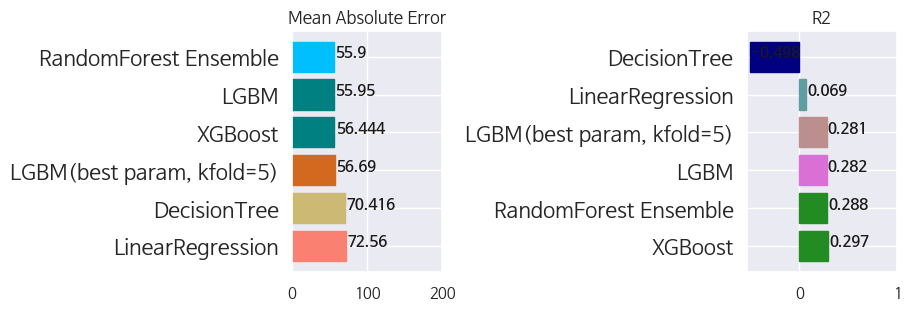

In [80]:
lgbm2 = LGBMRegressor(colsample_bytree = 0.7, learning_rate = 0.1, max_depth = 20)

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(y_train), total=5, desc="Processing folds"):
    X_t = X_train_reduced.iloc[train_idx]
    X_val = X_train_reduced.iloc[val_idx]
    
    y_t  = y_train.iloc[train_idx]
    y_val = y_train.iloc[val_idx]
    
    # 두 모델 모두 학습
    lgbm2.fit(X_t, y_t)
    
    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm2.predict(X_val)
    
    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))
    
    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm2_pred = lgbm2.predict(X_test_reduced)
    lgbm2_pred = np.where(lgbm2_pred < 0, 0, lgbm2_pred)
    
    ensemble_predictions.append(lgbm2_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

regression_eval('LGBM(best param, kfold=5)', lgbm2.predict(X_test_reduced), y_test)

In [83]:
from sklearn.linear_model import LinearRegression as lr
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.ensemble import GradientBoostingRegressor as grb
from xgboost import XGBRegressor as xgb
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error, r2_score

import pickle
import joblib
import time

model_list=[
            lr(),
            rfr(criterion='absolute_error'),
            grb(loss='absolute_error'),
            xgb(),
            ]

# 다차원 배열을 1차원으로 평평하게 만들어주기!
y_train = np.ravel(y_train, order='C')

model_rslt = []
for i in range(len(model_list)):
    
    start_time = time.process_time()
    
    model = model_list[i]
    model.fit(X_train, y_train)
    
    end_time = time.process_time()
    # joblib.dump(model, '{}_model.pkl'.format(i)) # 모델 저장, sklearn을 통해서 만들어진 모델은 pkl 파일로 저장
    
    print(f"* {model} 결과 시작")
    print('----  {0:.5f}sec, training complete  ----'.format(end_time-start_time))
    
    pred_y = model.predict(X_test)
    
    model_rslt.append(model)
    
    print("MAE on Test set : {0:.5f}".format(mean_absolute_error(y_test,pred_y)))
    print("R-squared Score on Test set : {0:.5f}".format(r2_score(y_test,pred_y)))
    print("---------------------------------------------------------------------------")

* LinearRegression() 결과 시작
----  0.12500sec, training complete  ----
MAE on Test set : 72.56008
R-squared Score on Test set : 0.06875
---------------------------------------------------------------------------
* RandomForestRegressor() 결과 시작
----  200.50000sec, training complete  ----
MAE on Test set : 55.89571
R-squared Score on Test set : 0.28822
---------------------------------------------------------------------------
* GradientBoostingRegressor() 결과 시작
----  32.95312sec, training complete  ----
MAE on Test set : 61.15723
R-squared Score on Test set : 0.21589
---------------------------------------------------------------------------
* XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
            

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2910
[LightGBM] [Info] Number of data points in the train set: 274356, number of used features: 26
[LightGBM] [Info] Start training from score 7.908056
* LGBMRegressor(objective='mae', seed=2023) 결과 시작
----  5.54688sec, training complete  ----
MAE on Test set : 45.52672
R-squared Score on Test set : 0.13987
---------------------------------------------------------------------------


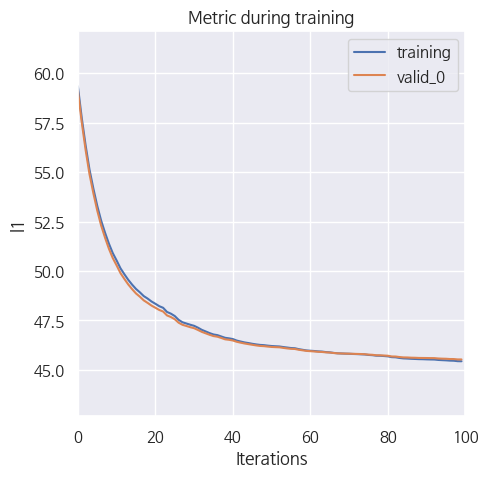

In [263]:
from sklearn.linear_model import LinearRegression as lr
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.ensemble import GradientBoostingRegressor as grb
from xgboost import XGBRegressor as xgb
import lightgbm
from lightgbm import LGBMRegressor as lgbmr
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error, r2_score

import pickle
import joblib
import time

model_list=[
            lgbmr(objective='mae', seed=2023),
            ]

# 다차원 배열을 1차원으로 평평하게 만들어주기!
y_train = np.ravel(y_train, order='C')

model_rslt = []
for i in range(len(model_list)):
    
    start_time = time.process_time()
    
    model = model_list[i]
    model.fit(X_train, y_train, 
              eval_set=[(X_test, y_test), (X_train, y_train)])
    
    end_time = time.process_time()
    # joblib.dump(model, '{}_model.pkl'.format(i)) # 모델 저장, sklearn을 통해서 만들어진 모델은 pkl 파일로 저장
    
    print(f"* {model} 결과 시작")
    print('----  {0:.5f}sec, training complete  ----'.format(end_time-start_time))
    
    pred_y = model.predict(X_test)
    
    model_rslt.append(model)
    
    print("MAE on Test set : {0:.5f}".format(mean_absolute_error(y_test,pred_y)))
    print("R-squared Score on Test set : {0:.5f}".format(r2_score(y_test,pred_y)))
    
    lightgbm.plot_metric(model, figsize=(5,5))
    print("---------------------------------------------------------------------------")

In [237]:
from sklearn.model_selection import GridSearchCV

In [264]:
LGBMR = model_rslt[0]

In [265]:
%%time

param_grid = {
    'learning_rate': [0.1, 0.01, 0.003],
    'colsample_bytree' : [0.5, 0.7],
    'max_depth' : [20, 30, 40]    
}

# 최적의 값 검색
cv_lgbmr = GridSearchCV(estimator=LGBMR,
                        param_grid=param_grid,
                        cv=5, 
                        verbose=1)

cv_lgbmr.fit(X_train, y_train)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2908
[LightGBM] [Info] Number of data points in the train set: 219484, number of used features: 26
[LightGBM] [Info] Start training from score 7.858056
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM

GridSearchCV(cv=5, estimator=LGBMRegressor(objective='mae', seed=2023),
             param_grid={'colsample_bytree': [0.5, 0.7],
                         'learning_rate': [0.1, 0.01, 0.003],
                         'max_depth': [20, 30, 40]},
             verbose=1)

In [266]:

#최적의 조합
print(cv_lgbmr.best_params_)
print(cv_lgbmr.best_score_)


{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 20}
0.088360843627627


In [267]:
# 머신러닝 모델 검증
# 최적의 하이퍼파라미터로 재학습
best_lgbmr = LGBMRegressor(max_depth=20,
                           colsample_bytree=0.7,
                           learning_rate=0.1,
                           n_jobs=-1,
                           random_state=1)

best_lgbmr.fit(X_train, y_train)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2909
[LightGBM] [Info] Number of data points in the train set: 274356, number of used features: 26
[LightGBM] [Info] Start training from score 61.990887


LGBMRegressor(colsample_bytree=0.7, max_depth=20, n_jobs=-1, random_state=1)

In [268]:
# 모델 성능
best_pred = best_lgbmr.predict(X_test)
# print('r2 : ', round(r2_score(y_test, best_pred), 5) )
print('mae : ', mean_absolute_error(y_test, best_pred) )


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
mae :  57.5048934424304


In [250]:
from sklearn.model_selection import RandomizedSearchCV

In [252]:
%%time

param_dists = {
    'learning_rate': [0.1, 0.01, 0.003],
    'colsample_bytree' : [0.5, 0.7],
    'max_depth' : [20, 30, 40]    
}

# 최적의 값 검색
cv_lgbmr = RandomizedSearchCV(estimator=LGBMR,
                        param_distributions=param_dists,
                        n_iter = 500,
                        cv=5, 
                        verbose=1)

cv_lgbmr.fit(X_train, y_train)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2909
[LightGBM] [Info] Number of data points in the train set: 219484, number of used features: 26
[LightGBM] [Info] Start training from score 61.820276
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGB

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(), n_iter=500,
                   param_distributions={'colsample_bytree': [0.5, 0.7],
                                        'learning_rate': [0.1, 0.01, 0.003],
                                        'max_depth': [20, 30, 40]},
                   verbose=1)

In [254]:
# 성능 확인
print(cv_lgbmr.best_params_)
print(cv_lgbmr.best_score_)

{'max_depth': 20, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
0.27959272989529815


### 7) Stacking

개별 모델이 예측한 데이터를 기반으로 **final_estimator** 종합하여 예측을 수행합니다.
- 성능을 극으로 끌어올릴 때 활용하기도 합니다.
- 과대적합을 유발할 수 있습니다. (특히, 데이터셋이 적은 경우)

In [ ]:
from sklearn.ensemble import StackingRegressor, StackingClassifier

: 

In [ ]:
stack_models = [
    ('LogisticRegression', lg), 
    ('KNN', knn), 
    ('DecisionTree', dt),
]

: 

In [ ]:
# stack_models로 선언된 모델(LogisticRegression,KNN,DecisionTree)의 예측결과를 최종 meta_model(final_estimator)을 RandomForest(rfc) 사용하여 분류 예측 
stacking = StackingClassifier(stack_models, final_estimator=rfc, n_jobs=-1)

: 

In [ ]:
stacking.fit(X_train, y_train)   # 1분 20초 소요

: 

In [ ]:
stacking_pred = stacking.predict(X_test)

: 

In [ ]:
accuracy_eval('Stacking Ensemble', stacking_pred, y_test)

: 

### 8) Weighted Blending

각 모델의 예측값에 대하여 weight를 곱하여 최종 output 계산
- 모델에 대한 가중치를 조절하여, 최종 output을 산출합니다.
- **가중치의 합은 1.0**이 되도록 합니다.

In [ ]:
final_outputs = {
    'DecisionTree': dt_pred, 
    'randomforest': rfc_pred, 
    'xgb': xgb_pred, 
    'lgbm': lgbm_pred,
    'stacking': stacking_pred,
} #각각의 예측값

: 

In [ ]:
final_prediction=\
final_outputs['DecisionTree'] * 0.1\
+final_outputs['randomforest'] * 0.2\
+final_outputs['xgb'] * 0.25\
+final_outputs['lgbm'] * 0.15\
+final_outputs['stacking'] * 0.3\
#각각 가중치를 곱한다.

: 

In [ ]:
# 가중치 계산값이 0.5 초과하면 1, 그렇지 않으면 0
final_prediction = np.where(final_prediction > 0.5, 1, 0)

: 

In [ ]:
accuracy_eval('Weighted Blending', final_prediction, y_test)

: 

: 

: 

: 